In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

C:\Users\dell\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


In [3]:
batch_size=128
epochs=10
log_interval = 10

In [4]:
train_data=datasets.MNIST(
    root='MNIST',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
test_data=datasets.MNIST(
    root='MNIST',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST\MNIST\raw\train-images-idx3-ubyte.gz to MNIST\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\MNIST\raw



In [5]:
from torch.utils.data import DataLoader

In [6]:
train_loader=DataLoader(dataset=train_data,batch_size=128,shuffle=True)
test_loader=DataLoader(dataset=test_data,batch_size=128,shuffle=True)

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE()

model = model.cuda()

reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False

def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x.view(-1, 784))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
   KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

   return BCE + KLD


optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [8]:
def loss_function(recon_x, x, mu, logvar):
    """
    :param recon_x: generated image
    :param x: original image
    :param mu: latent mean of z
    :param logvar: latent log variance of z
    """
    BCE_loss = nn.BCELoss(reduction='sum')
    reconstruction_loss = BCE_loss(recon_x, x)
    KL_divergence = -0.5 * torch.sum(1+logvar-torch.exp(logvar)-mu**2)
    #KLD_ele = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    #KLD = torch.sum(KLD_ele).mul_(-0.5)
    #print(reconstruction_loss, KL_divergence)

    return reconstruction_loss + KL_divergence

optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [9]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = torch.flatten(data, start_dim=1)
            
        data = Variable(data)
        data = data.cuda()
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        #train_loss += loss.data[0].item()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()/ len(data)))
            

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


In [10]:
def test(epoch):
    model.eval()
    test_loss = 0
    for data, _ in test_loader:
        data = torch.flatten(data, start_dim=1)
        
        data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [11]:
for epoch in range(20):
    train(epoch)
    test(epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 548.946899
Train Epoch: 0 [1280/60000 (2%)]	Loss: 466.735321
Train Epoch: 0 [2560/60000 (4%)]	Loss: 364.735596
Train Epoch: 0 [3840/60000 (6%)]	Loss: 296.344666
Train Epoch: 0 [5120/60000 (9%)]	Loss: 260.867554
Train Epoch: 0 [6400/60000 (11%)]	Loss: 248.070862
Train Epoch: 0 [7680/60000 (13%)]	Loss: 238.226730
Train Epoch: 0 [8960/60000 (15%)]	Loss: 230.579041
Train Epoch: 0 [10240/60000 (17%)]	Loss: 230.717865
Train Epoch: 0 [11520/60000 (19%)]	Loss: 217.459991
Train Epoch: 0 [12800/60000 (21%)]	Loss: 228.901001
Train Epoch: 0 [14080/60000 (23%)]	Loss: 215.922485
Train Epoch: 0 [15360/60000 (26%)]	Loss: 218.032745
Train Epoch: 0 [16640/60000 (28%)]	Loss: 213.523361
Train Epoch: 0 [17920/60000 (30%)]	Loss: 226.292160
Train Epoch: 0 [19200/60000 (32%)]	Loss: 205.217712
Train Epoch: 0 [20480/60000 (34%)]	Loss: 198.604294
Train Epoch: 0 [21760/60000 (36%)]	Loss: 201.819672
Train Epoch: 0 [23040/60000 (38%)]	Loss: 191.741013
Train Epoch: 0 [24320/60000 

C:\Users\dell\AppData\Local\Temp\ipykernel_18616\194371317.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True)


====> Test set loss: 154.8200
Train Epoch: 1 [0/60000 (0%)]	Loss: 149.634262
Train Epoch: 1 [1280/60000 (2%)]	Loss: 149.229431
Train Epoch: 1 [2560/60000 (4%)]	Loss: 157.230637
Train Epoch: 1 [3840/60000 (6%)]	Loss: 150.369995
Train Epoch: 1 [5120/60000 (9%)]	Loss: 152.494202
Train Epoch: 1 [6400/60000 (11%)]	Loss: 154.351486
Train Epoch: 1 [7680/60000 (13%)]	Loss: 152.738800
Train Epoch: 1 [8960/60000 (15%)]	Loss: 154.166565
Train Epoch: 1 [10240/60000 (17%)]	Loss: 152.219391
Train Epoch: 1 [11520/60000 (19%)]	Loss: 151.797516
Train Epoch: 1 [12800/60000 (21%)]	Loss: 144.826660
Train Epoch: 1 [14080/60000 (23%)]	Loss: 149.520264
Train Epoch: 1 [15360/60000 (26%)]	Loss: 146.518173
Train Epoch: 1 [16640/60000 (28%)]	Loss: 149.737183
Train Epoch: 1 [17920/60000 (30%)]	Loss: 141.571686
Train Epoch: 1 [19200/60000 (32%)]	Loss: 146.652252
Train Epoch: 1 [20480/60000 (34%)]	Loss: 146.878891
Train Epoch: 1 [21760/60000 (36%)]	Loss: 148.367035
Train Epoch: 1 [23040/60000 (38%)]	Loss: 145.13491

Train Epoch: 4 [17920/60000 (30%)]	Loss: 119.053131
Train Epoch: 4 [19200/60000 (32%)]	Loss: 119.009018
Train Epoch: 4 [20480/60000 (34%)]	Loss: 115.246140
Train Epoch: 4 [21760/60000 (36%)]	Loss: 118.115860
Train Epoch: 4 [23040/60000 (38%)]	Loss: 118.726387
Train Epoch: 4 [24320/60000 (41%)]	Loss: 118.266266
Train Epoch: 4 [25600/60000 (43%)]	Loss: 118.517426
Train Epoch: 4 [26880/60000 (45%)]	Loss: 118.973274
Train Epoch: 4 [28160/60000 (47%)]	Loss: 118.912918
Train Epoch: 4 [29440/60000 (49%)]	Loss: 116.068115
Train Epoch: 4 [30720/60000 (51%)]	Loss: 116.901176
Train Epoch: 4 [32000/60000 (53%)]	Loss: 116.344131
Train Epoch: 4 [33280/60000 (55%)]	Loss: 119.905640
Train Epoch: 4 [34560/60000 (58%)]	Loss: 117.541397
Train Epoch: 4 [35840/60000 (60%)]	Loss: 121.034149
Train Epoch: 4 [37120/60000 (62%)]	Loss: 115.156097
Train Epoch: 4 [38400/60000 (64%)]	Loss: 118.291443
Train Epoch: 4 [39680/60000 (66%)]	Loss: 119.244949
Train Epoch: 4 [40960/60000 (68%)]	Loss: 113.715683
Train Epoch:

Train Epoch: 7 [35840/60000 (60%)]	Loss: 111.570435
Train Epoch: 7 [37120/60000 (62%)]	Loss: 111.188828
Train Epoch: 7 [38400/60000 (64%)]	Loss: 111.482811
Train Epoch: 7 [39680/60000 (66%)]	Loss: 110.530075
Train Epoch: 7 [40960/60000 (68%)]	Loss: 113.365173
Train Epoch: 7 [42240/60000 (70%)]	Loss: 115.057381
Train Epoch: 7 [43520/60000 (72%)]	Loss: 110.648338
Train Epoch: 7 [44800/60000 (75%)]	Loss: 113.876434
Train Epoch: 7 [46080/60000 (77%)]	Loss: 106.159286
Train Epoch: 7 [47360/60000 (79%)]	Loss: 110.540237
Train Epoch: 7 [48640/60000 (81%)]	Loss: 109.620789
Train Epoch: 7 [49920/60000 (83%)]	Loss: 112.013046
Train Epoch: 7 [51200/60000 (85%)]	Loss: 113.622948
Train Epoch: 7 [52480/60000 (87%)]	Loss: 112.331711
Train Epoch: 7 [53760/60000 (90%)]	Loss: 110.758347
Train Epoch: 7 [55040/60000 (92%)]	Loss: 111.708351
Train Epoch: 7 [56320/60000 (94%)]	Loss: 111.541451
Train Epoch: 7 [57600/60000 (96%)]	Loss: 108.702370
Train Epoch: 7 [58880/60000 (98%)]	Loss: 112.027885
====> Epoch:

Train Epoch: 10 [53760/60000 (90%)]	Loss: 109.037323
Train Epoch: 10 [55040/60000 (92%)]	Loss: 111.282860
Train Epoch: 10 [56320/60000 (94%)]	Loss: 105.860596
Train Epoch: 10 [57600/60000 (96%)]	Loss: 110.561340
Train Epoch: 10 [58880/60000 (98%)]	Loss: 105.950768
====> Epoch: 10 Average loss: 109.6459
====> Test set loss: 108.6038
Train Epoch: 11 [0/60000 (0%)]	Loss: 107.055893
Train Epoch: 11 [1280/60000 (2%)]	Loss: 112.553185
Train Epoch: 11 [2560/60000 (4%)]	Loss: 108.192535
Train Epoch: 11 [3840/60000 (6%)]	Loss: 112.933594
Train Epoch: 11 [5120/60000 (9%)]	Loss: 109.776733
Train Epoch: 11 [6400/60000 (11%)]	Loss: 111.708069
Train Epoch: 11 [7680/60000 (13%)]	Loss: 110.801369
Train Epoch: 11 [8960/60000 (15%)]	Loss: 108.445435
Train Epoch: 11 [10240/60000 (17%)]	Loss: 111.365654
Train Epoch: 11 [11520/60000 (19%)]	Loss: 104.486313
Train Epoch: 11 [12800/60000 (21%)]	Loss: 105.166649
Train Epoch: 11 [14080/60000 (23%)]	Loss: 107.683769
Train Epoch: 11 [15360/60000 (26%)]	Loss: 111.

Train Epoch: 14 [7680/60000 (13%)]	Loss: 108.701416
Train Epoch: 14 [8960/60000 (15%)]	Loss: 106.955315
Train Epoch: 14 [10240/60000 (17%)]	Loss: 110.574127
Train Epoch: 14 [11520/60000 (19%)]	Loss: 108.540962
Train Epoch: 14 [12800/60000 (21%)]	Loss: 106.387497
Train Epoch: 14 [14080/60000 (23%)]	Loss: 105.256485
Train Epoch: 14 [15360/60000 (26%)]	Loss: 109.477310
Train Epoch: 14 [16640/60000 (28%)]	Loss: 110.595947
Train Epoch: 14 [17920/60000 (30%)]	Loss: 109.157890
Train Epoch: 14 [19200/60000 (32%)]	Loss: 106.997871
Train Epoch: 14 [20480/60000 (34%)]	Loss: 104.277710
Train Epoch: 14 [21760/60000 (36%)]	Loss: 108.278305
Train Epoch: 14 [23040/60000 (38%)]	Loss: 108.501129
Train Epoch: 14 [24320/60000 (41%)]	Loss: 104.084000
Train Epoch: 14 [25600/60000 (43%)]	Loss: 106.316444
Train Epoch: 14 [26880/60000 (45%)]	Loss: 105.395828
Train Epoch: 14 [28160/60000 (47%)]	Loss: 107.137100
Train Epoch: 14 [29440/60000 (49%)]	Loss: 105.985741
Train Epoch: 14 [30720/60000 (51%)]	Loss: 107.57

Train Epoch: 17 [23040/60000 (38%)]	Loss: 105.641975
Train Epoch: 17 [24320/60000 (41%)]	Loss: 109.473541
Train Epoch: 17 [25600/60000 (43%)]	Loss: 107.398521
Train Epoch: 17 [26880/60000 (45%)]	Loss: 100.247086
Train Epoch: 17 [28160/60000 (47%)]	Loss: 107.804901
Train Epoch: 17 [29440/60000 (49%)]	Loss: 106.193069
Train Epoch: 17 [30720/60000 (51%)]	Loss: 108.489861
Train Epoch: 17 [32000/60000 (53%)]	Loss: 110.502121
Train Epoch: 17 [33280/60000 (55%)]	Loss: 104.932297
Train Epoch: 17 [34560/60000 (58%)]	Loss: 111.624481
Train Epoch: 17 [35840/60000 (60%)]	Loss: 113.862091
Train Epoch: 17 [37120/60000 (62%)]	Loss: 102.572113
Train Epoch: 17 [38400/60000 (64%)]	Loss: 105.897552
Train Epoch: 17 [39680/60000 (66%)]	Loss: 105.693611
Train Epoch: 17 [40960/60000 (68%)]	Loss: 109.033257
Train Epoch: 17 [42240/60000 (70%)]	Loss: 109.050644
Train Epoch: 17 [43520/60000 (72%)]	Loss: 108.116295
Train Epoch: 17 [44800/60000 (75%)]	Loss: 108.900528
Train Epoch: 17 [46080/60000 (77%)]	Loss: 105.

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [21]:
data = torch.rand(1,28,28)
data = data.cuda()
recon_batch, mu, logvar = model(data)
print(recon_batch.shape,mu.shape,logvar.shape)

torch.Size([1, 784]) torch.Size([1, 20]) torch.Size([1, 20])


torch.Size([28, 28])
torch.Size([1, 784]) tensor([[ 0.5432, -1.6502,  0.3370,  0.2152, -2.3163,  0.6593, -1.7756, -0.3910,
         -0.1722,  1.0038, -1.3455,  1.1361,  0.7083, -0.2137, -1.3699,  0.0815,
         -0.6160, -0.3507, -0.8501, -0.0521]], device='cuda:0',
       grad_fn=<AddmmBackward0>) tensor([[-1.7752, -3.3116, -1.4625, -3.2386, -2.1979, -2.3793, -2.2774, -3.4573,
         -2.3108, -3.0393, -2.2108, -2.1012, -1.7160, -1.9114, -2.0997, -2.6841,
         -3.7641, -2.4304, -3.1339, -3.5633]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
torch.Size([28, 28])


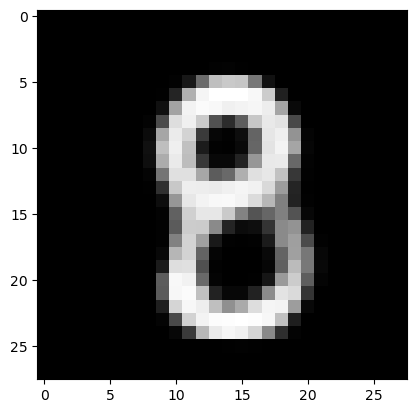

In [31]:
#x,y=next(iter(test_loader))
print(x[0].shape)
x = x[0]
x = x.cuda()
recon_batch, mu, logvar = model(x)
print(recon_batch.shape,mu,logvar)
img=recon_batch.reshape(28,28)
img = img.cpu().detach()
print(img.shape)
img = img.numpy()
plt.imshow(img,cmap ='gray')
#plt.colorbar()
plt.show()

torch.Size([28, 28])


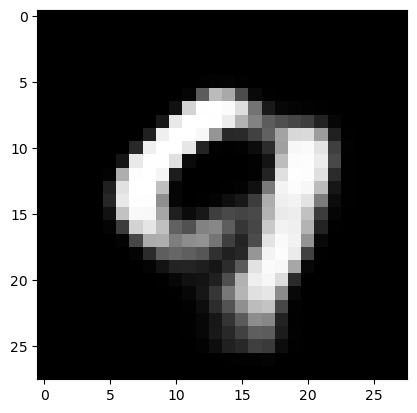

In [34]:
data = torch.randn(1,20)
data = data.cuda()
y=model.decode(data)
img=y.reshape(28,28)
img = img.cpu().detach()
print(img.shape)
img = img.numpy()
plt.imshow(img,cmap ='gray')
#plt.colorbar()
plt.show()